## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## Plotter
***

In [3]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.1.2.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (Chevron)             : (2399, 12)
Field Case 2      : (AkerBP)              : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


In [4]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult*torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

In [5]:
chevron_model      = ResInvPINN(hidden_dim=150).to(device)
chevron_model.load_state_dict(torch.load('models/model_Chevron.pth'))
chevron_results    = pd.read_csv('results/pinn_solution_Chevron.csv', index_col=0)
chevron_gb_results = pd.read_csv('results/gradient_based_solution_Chevron.csv', index_col=0)
chevron_data       = lasio.read('cases/well1.las').df().loc[chevron_results.index]
chevron_all        = chevron_data.merge(chevron_results).set_index(chevron_results.index)

akerbp_model       = ResInvPINN(hidden_dim=150).to(device)
akerbp_model.load_state_dict(torch.load('models/model_AkerBP.pth'))
akerbp_results     = pd.read_csv('results/pinn_solution_AkerBP.csv', index_col=0)
akerbp_gb_results  = pd.read_csv('results/gradient_based_solution_AkerBP.csv', index_col=0)
akerbp_data        = lasio.read('cases/well2.LAS').df().loc[akerbp_results.index]
akerbp_all         = akerbp_data.merge(akerbp_results).set_index(akerbp_results.index)

synth1_model       = ResInvPINN(hidden_dim=150).to(device)
synth1_model.load_state_dict(torch.load('models/model_synthetic1.pth'))
synth1_results     = pd.read_csv('results/pinn_solution_synthetic1.csv', index_col=0)
synth1_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic1.csv', index_col=0).iloc[22:]
synthetic1_data     = lasio.read('cases/Case1.las').df().join(lasio.read('cases/Case1_RvRh.las').df()).loc[synth1_results.index]
synthetic1_all     = synthetic1_data.merge(synth1_results, left_index=True, right_index=True)

synth2_model       = ResInvPINN(hidden_dim=150).to(device)
synth2_model.load_state_dict(torch.load('models/model_synthetic2.pth'))
synth2_results     = pd.read_csv('results/pinn_solution_synthetic2.csv', index_col=0)
synth2_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic2.csv', index_col=0)
synthetic2_data    = lasio.read('cases/Case2.las').df().loc[synth2_results.index]
synthetic2_all     = synthetic2_data.merge(synth2_results).set_index(synth2_results.index)

In [63]:
runit = '$\Omega\cdot m$'

***

In [136]:
akerbp_data.columns

Index(['HCGR', 'HCAL', 'HFK', 'HTHO', 'HURA', 'AT10', 'AT20', 'AT30', 'AT60',
       'AT90', 'RH72_1DF', 'RV72_1DF', 'RHOZ', 'TNPH', 'HDRA', 'PEFZ', 'DTCO',
       'DTSM'],
      dtype='object')

In [137]:
akerbp_results.columns

Index(['CAL', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh', 'Rvsh', 'Rhsh',
       'WNAME', 'WIDX', 'Csh_pred', 'Rss_pred', 'Rv_sim', 'Rh_sim', 'Rv_err',
       'Rh_err', 'Csh_q', 'Rss_q', 'Rv_sim_q', 'Rh_sim_q'],
      dtype='object')

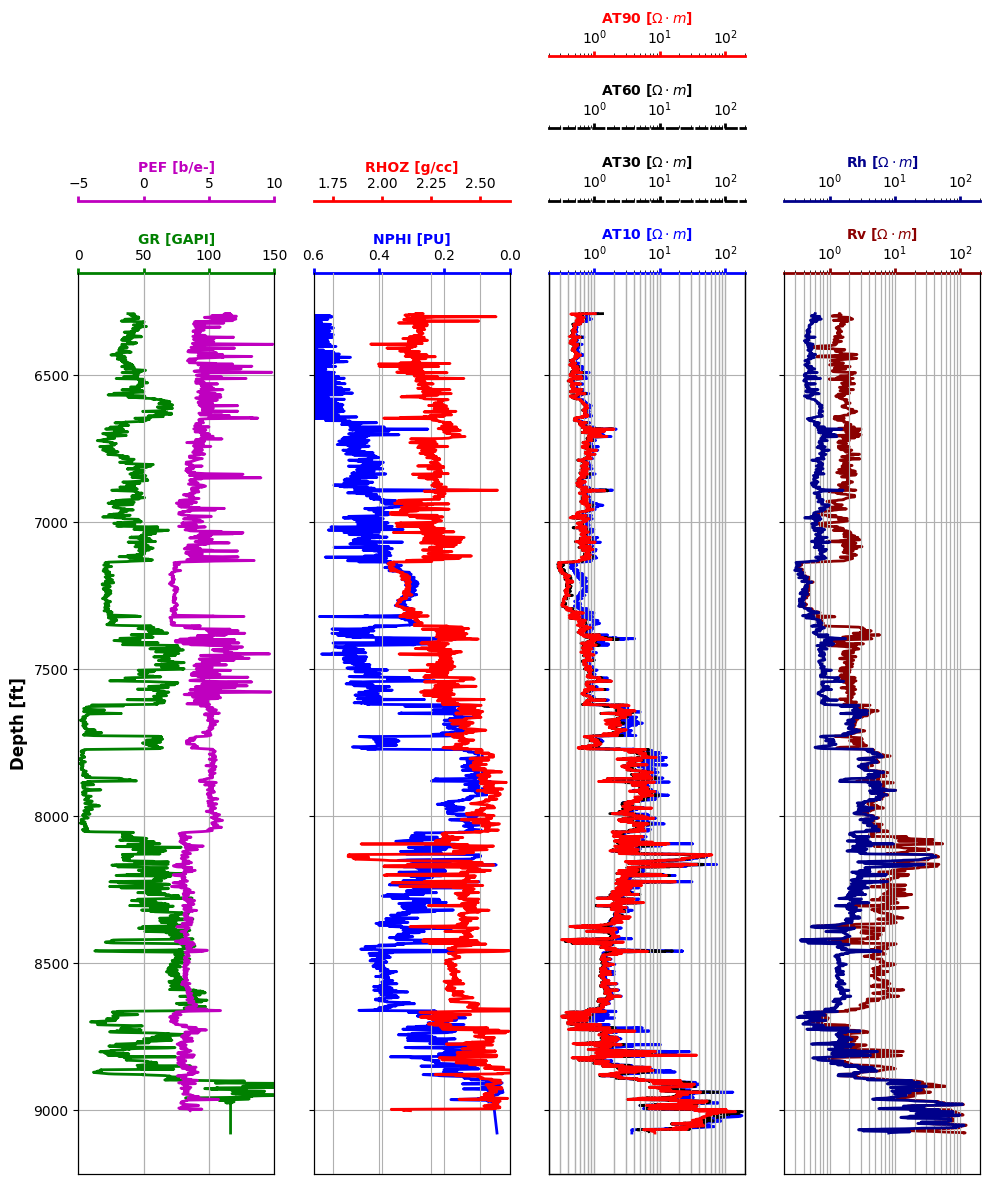

In [140]:
fig, axs = plt.subplots(1, 4, figsize=(10, 12), sharey=True)
ax1, ax2, ax3, ax4 = axs

rlb, rub = 0.2, 200

ax11 = ax1.twiny()
plot_curve(ax1, akerbp_results, 'GR', label='GR', units='GAPI', lb=0, ub=150, color='g')
plot_curve(ax11, akerbp_data, 'PEFZ', label='PEF', units='b/e-', lb=-5, ub=10, color='m', pad=8)

ax21 = ax2.twiny()
plot_curve(ax2, akerbp_data, 'TNPH', label='NPHI', units='PU', lb=0.6, ub=0.0, color='b')
plot_curve(ax21, akerbp_data, 'RHOZ', label='RHOZ', units='g/cc', lb=1.65, ub=2.65, color='r', pad=8)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
plot_curve(ax3, akerbp_data, 'AT10', label='AT10', units=runit, lb=rlb, ub=rub, semilog=True, color='b')
plot_curve(ax31, akerbp_data, 'AT30', label='AT30', units=runit, lb=rlb, ub=rub, semilog=True, color='k', ls='--', pad=8)
plot_curve(ax32, akerbp_data, 'AT60', label='AT60', units=runit, lb=rlb, ub=rub, semilog=True, color='k', ls='--', pad=16)
plot_curve(ax33, akerbp_data, 'AT90', label='AT90', units=runit, lb=rlb, ub=rub, semilog=True, color='r', pad=24)

ax41 = ax4.twiny()
plot_curve(ax4, akerbp_results, 'Rv', label='Rv', units=runit, lb=rlb, ub=rub, semilog=True, color='darkred')
plot_curve(ax41, akerbp_results, 'Rh', label='Rh', units=runit, lb=rlb, ub=rub, semilog=True, color='darkblue', pad=8)

ax1.set_ylabel('Depth [ft]', weight='bold', fontsize=12)
ax1.invert_yaxis()
plt.tight_layout()
plt.savefig('paper/figures/real2-suite.png', dpi=600)
plt.show()

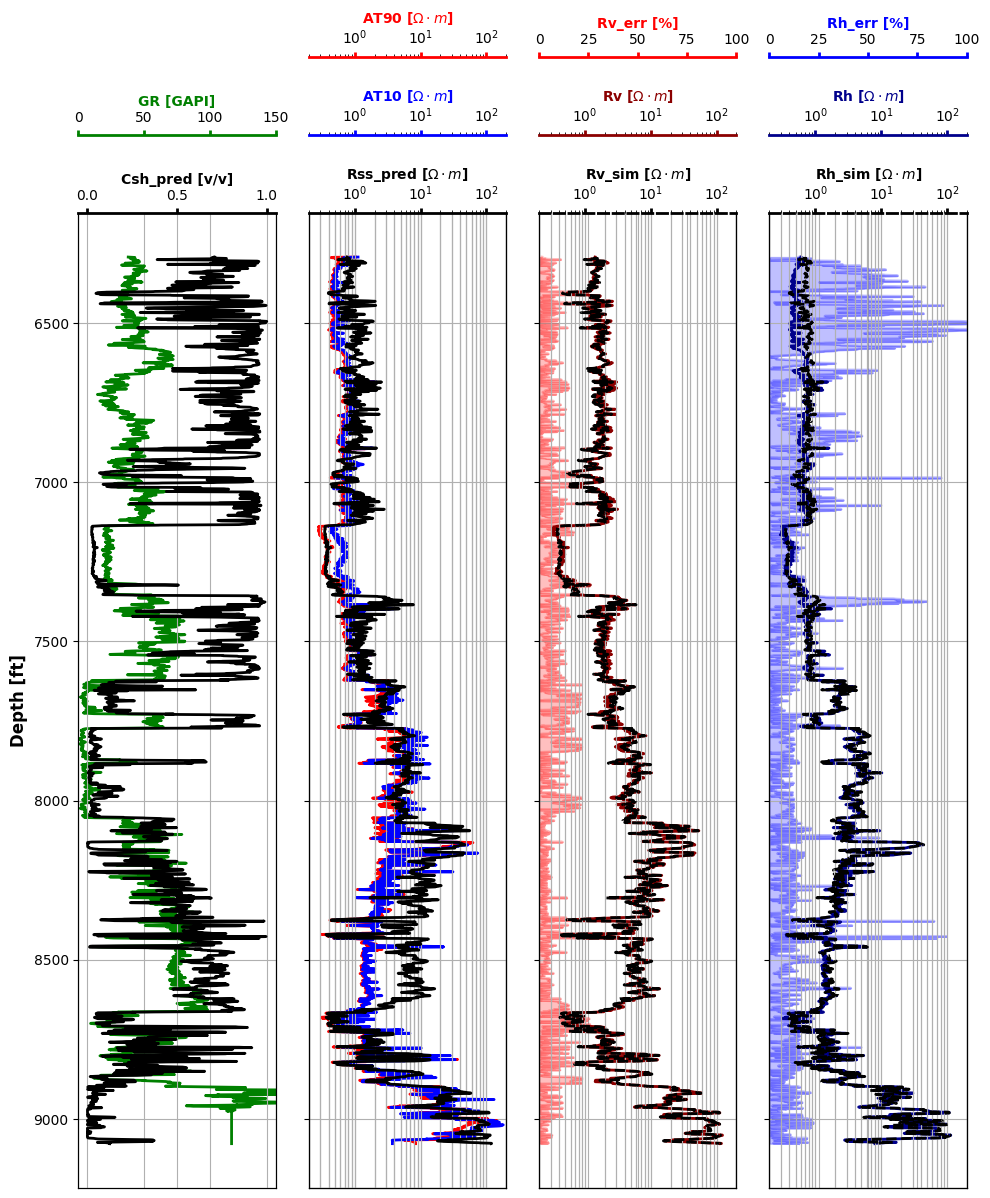

In [141]:
fig, axs = plt.subplots(1, 4, figsize=(10, 12), sharey=True)
ax1, ax2, ax3, ax4 = axs

rlb, rub = 0.2, 200

ax11 = ax1.twiny()
plot_curve(ax1, akerbp_results, 'GR', label='GR', units='GAPI', lb=0, ub=150, color='g', pad=8)
plot_curve(ax11, akerbp_results, 'Csh_pred', label='Csh_pred', units='v/v', lb=-0.05, ub=1.05, color='k')

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax22, akerbp_results, 'Rss_pred', label='Rss_pred', units=runit, lb=rlb, ub=rub, semilog=True, color='k')
plot_curve(ax21, akerbp_results, 'AT10', label='AT10', units=runit, lb=rlb, ub=rub, semilog=True, color='b', pad=8)
plot_curve(ax2, akerbp_results, 'AT90', label='AT90', units=runit, lb=rlb, ub=rub, semilog=True, color='r', pad=16)


ax31, ax32 = ax3.twiny(), ax3.twiny()
plot_curve(ax32, akerbp_results, 'Rv_sim', label='Rv_sim', units=runit, lb=rlb, ub=rub, semilog=True, color='k', ls='--')
plot_curve(ax31, akerbp_results, 'Rv', label='Rv', units=runit, lb=rlb, ub=rub, semilog=True, color='darkred', pad=8)
plot_curve(ax3, akerbp_results, 'Rv_err', label='Rv_err', units='%', lb=0, ub=100, fill=True, alpha=0.25, color='r', pad=16)

ax41, ax42 = ax4.twiny(), ax4.twiny()
plot_curve(ax42, akerbp_results, 'Rh_sim', label='Rh_sim', units=runit, lb=rlb, ub=rub, semilog=True, color='k', ls='--')
plot_curve(ax41, akerbp_results, 'Rh', label='Rh', units=runit, lb=rlb, ub=rub, semilog=True, color='darkblue', pad=8)
plot_curve(ax4, akerbp_results, 'Rh_err', label='Rh_err', units='%', lb=0, ub=100, fill=True, alpha=0.25, color='b', pad=16)

ax1.set_ylabel('Depth [ft]', weight='bold', fontsize=12)
ax1.invert_yaxis()
plt.tight_layout()
plt.savefig('paper/figures/real2-pinn.png', dpi=600)
plt.show()

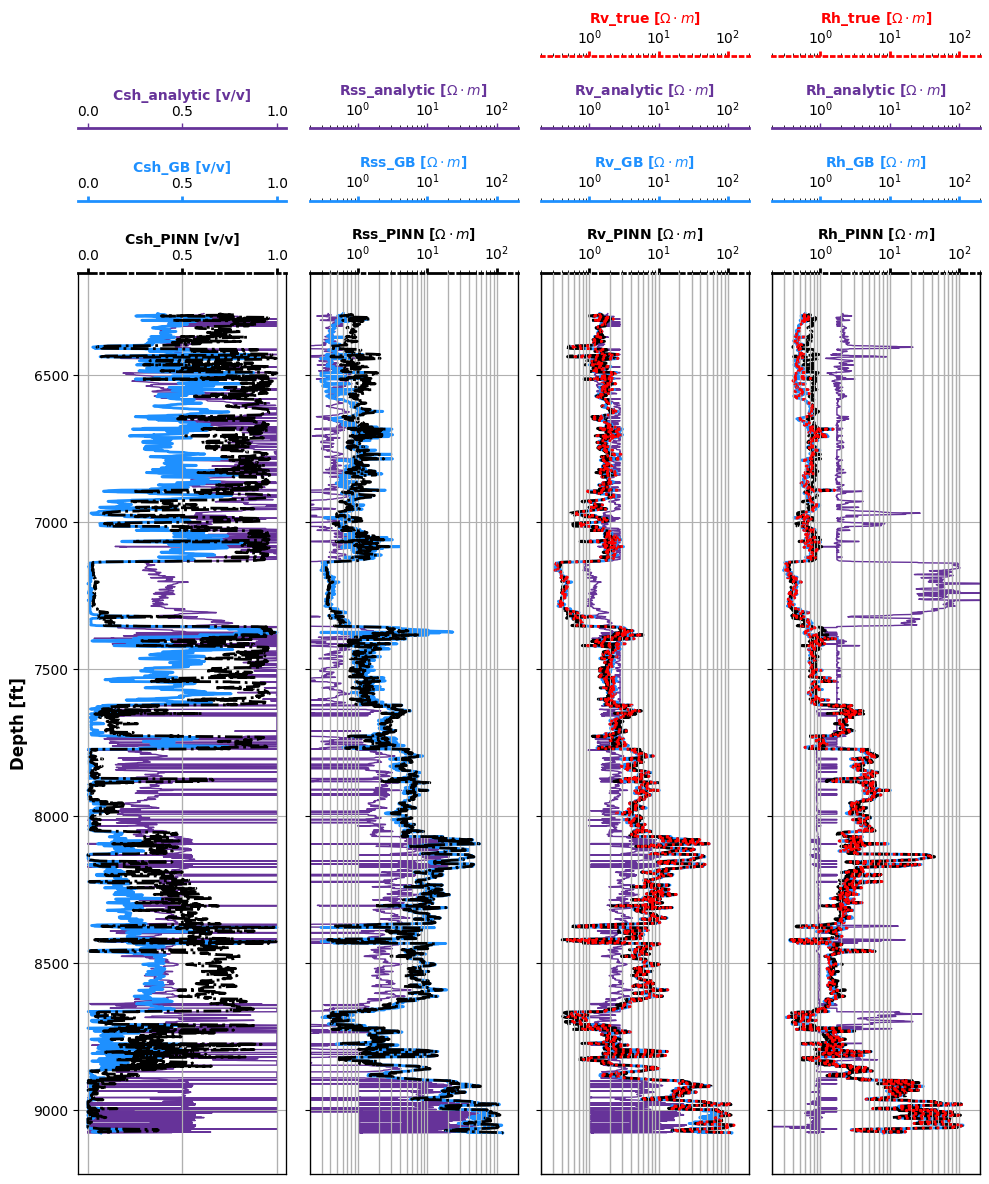

In [145]:
fig, axs = plt.subplots(1, 4, figsize=(10, 12), sharey=True)
ax1, ax2, ax3, ax4 = axs

rlb, rub = 0.2, 200

ax11, ax12 = ax1.twiny(), ax1.twiny()
plot_curve(ax12, akerbp_results, 'Csh_pred', label='Csh_PINN', units='v/v', lb=-0.05, ub=1.05, color='k', ls='-.')
plot_curve(ax11, akerbp_gb_results, 'Csh_pred', label='Csh_GB', units='v/v', lb=-0.05, ub=1.05, color='dodgerblue', pad=8)
plot_curve(ax1, akerbp_results, 'Csh_q', label='Csh_analytic', units='v/v', lb=-0.05, ub=1.05, color='rebeccapurple', ls='-', s=1, pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax22, akerbp_results, 'Rss_pred', label='Rss_PINN', units=runit, lb=rlb, ub=rub, semilog=True, color='k', ls='-.')
plot_curve(ax21, akerbp_gb_results, 'Rss_pred', label='Rss_GB', units=runit, lb=rlb, ub=rub, semilog=True, color='dodgerblue', pad=8)
plot_curve(ax2, akerbp_results, 'Rss_q', label='Rss_analytic', units=runit, lb=rlb, ub=rub, semilog=True, color='rebeccapurple', ls='-', s=1, pad=16)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
plot_curve(ax33, akerbp_results, 'Rv', label='Rv_true', units=runit, lb=rlb, ub=rub, semilog=True, color='r', ls=':', pad=24)
plot_curve(ax32, akerbp_results, 'Rv_sim', label='Rv_PINN', units=runit, lb=rlb, ub=rub, semilog=True, color='k', ls='-.')
plot_curve(ax31, akerbp_gb_results, 'Rv_sim', label='Rv_GB', units=runit, lb=rlb, ub=rub, semilog=True, color='dodgerblue', pad=8)
plot_curve(ax3, akerbp_results, 'Rv_sim_q', label='Rv_analytic', units=runit, lb=rlb, ub=rub, semilog=True, color='rebeccapurple', ls='-', s=1, pad=16)

ax41, ax42, ax43 = ax4.twiny(), ax4.twiny(), ax4.twiny()
plot_curve(ax43, akerbp_results, 'Rh', label='Rh_true', units=runit, lb=rlb, ub=rub, semilog=True, color='r', ls=':', pad=24)
plot_curve(ax42, akerbp_results, 'Rh_sim', label='Rh_PINN', units=runit, lb=rlb, ub=rub, semilog=True, color='k', ls='-.')
plot_curve(ax41, akerbp_gb_results, 'Rh_sim', label='Rh_GB', units=runit, lb=rlb, ub=rub, semilog=True, color='dodgerblue', pad=8)
plot_curve(ax4, akerbp_results, 'Rh_sim_q', label='Rh_analytic', units=runit, lb=rlb, ub=rub, semilog=True, color='rebeccapurple', ls='-', s=1, pad=16)

ax1.set_ylabel('Depth [ft]', weight='bold', fontsize=12)
ax1.invert_yaxis()
plt.tight_layout()
plt.savefig('paper/figures/real2_compare.png', dpi=600)
plt.show()

***
# END